# Qualité de l'air de la station Châtelet
 
# Partie 2 : Analyse Exploratoire des données

-------------------

#### Sommaire

* Librairies
* Données
* Création du Validation set
* Analyse Exploratoire des données
    * Période concernée
    * Indicateurs Statistiques
    * Line Plots
    * Density plot
    * Box Plots



# Librairies

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
#---------------------------------------------------------------------#
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
#---------------------------------------------------------------------#
from sklearn.metrics import mean_squared_error
#---------------------------------------------------------------------#
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
pd.options.display.max_rows = 50

# Données

In [3]:
series_co2 = pd.read_csv('datasets/data_co2_ext.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [4]:
series_co2.head()

dateheure
2020-06-01 00:00:00+00:00    427.0
2020-06-01 01:00:00+00:00    421.0
2020-06-01 02:00:00+00:00    421.0
2020-06-01 03:00:00+00:00    421.0
2020-06-01 04:00:00+00:00    421.0
Name: c2cha4, dtype: float64

In [5]:
print("nombre d'observations : %i" % len(series_co2))
print(f"période : {series_co2.index.min()} - {series_co2.index.max()}")
print("valeurs manquantes :", series_co2.isna().sum())

nombre d'observations : 11089
période : 2020-06-01 00:00:00+00:00 - 2021-09-13 00:00:00+00:00
valeurs manquantes : 0


# Création du Validation set

Nous réservons les valeurs correspondant à une période de deux mois pour l'évaluation finale du modèle. 

62 jours x 24 h = 1488 observations

In [7]:
# séparer les données
nb_jours_reserv = 31 * 2
split_point = len(series_co2) - (24 * nb_jours_reserv)
dataset, validation = series_co2[0:split_point], series_co2[split_point:]

# vérifier les longueurs
print('dataset : %d, testset : %d' % (len(dataset), len(validation)))

# sauvegarder les deux échantillons
dataset.to_csv('datasets/dataset.csv', header=False)
validation.to_csv('datasets/validation.csv', header=False)

dataset : 9601, testset : 1488


# Analyse Exploratoire des données

Nous analysons uniquement 'dataset'. 

## Période concernée

In [8]:
print(f"période : {dataset.index.min()} - {dataset.index.max()}")

période : 2020-06-01 00:00:00+00:00 - 2021-07-13 00:00:00+00:00


## Indicateurs Statistiques

In [9]:
dataset.describe()

count    9601.000000
mean      492.229403
std        60.376402
min       385.000000
25%       442.000000
50%       484.000000
75%       531.000000
max       870.000000
Name: c2cha4, dtype: float64

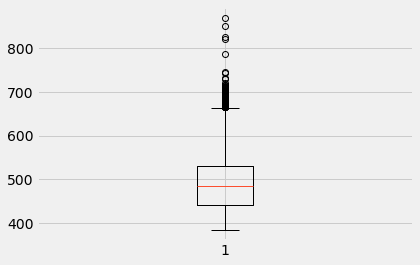

In [10]:
plt.boxplot(dataset);

## Line Plots

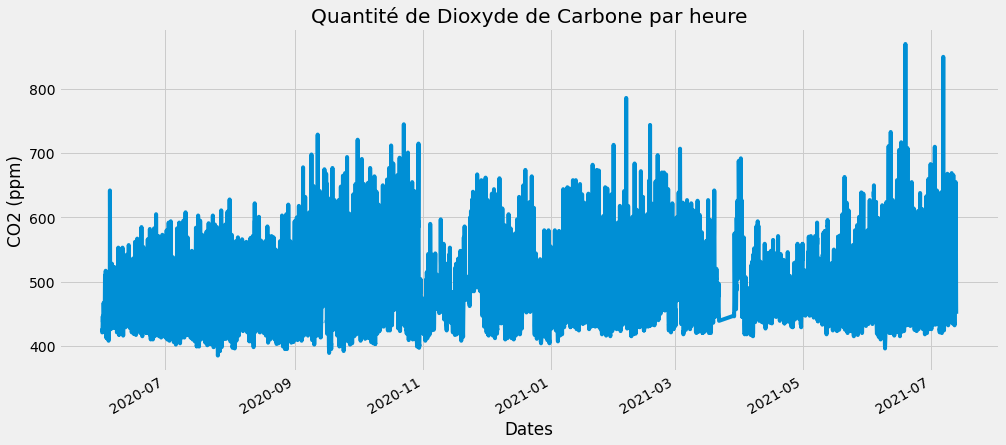

In [11]:
dataset.plot(figsize=(15,7))
plt.title('Quantité de Dioxyde de Carbone par heure')
plt.xlabel('Dates')
plt.ylabel('CO2 (ppm)'); 

Le graphique est difficilement lisible.  
Il ne semble pas y avoir de tendance ou de saisonnalité.  
Les outliers observés dans le box-plot se situent en juin-juillet 2021, peut-être des pics de pollution sur Paris pendant l'été. Si on se réfère à l'année qui précède, il ne s'agirait pas d'un phénomène annuel, mais on sortait à peine du 1e confinement ... Il faudrait regarder sur des données plus anciennes si nécessaire.

### Regroupement par mois

Rappelons que le mois de juillet est incomplet. 

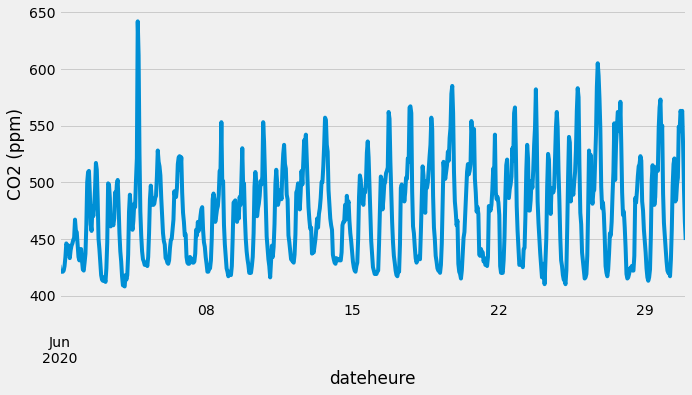

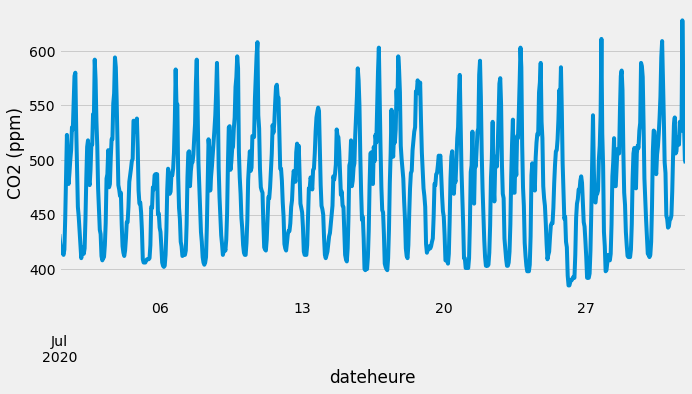

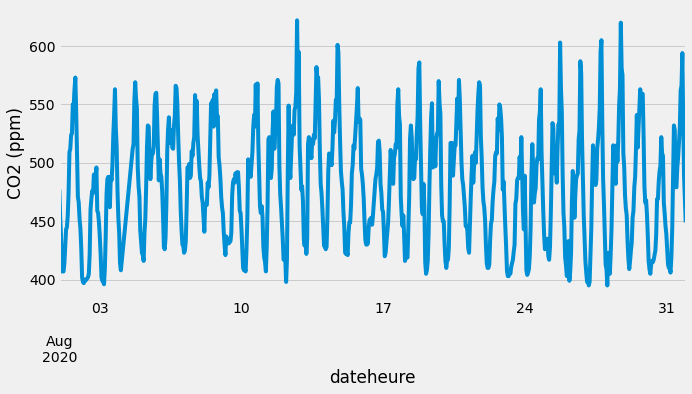

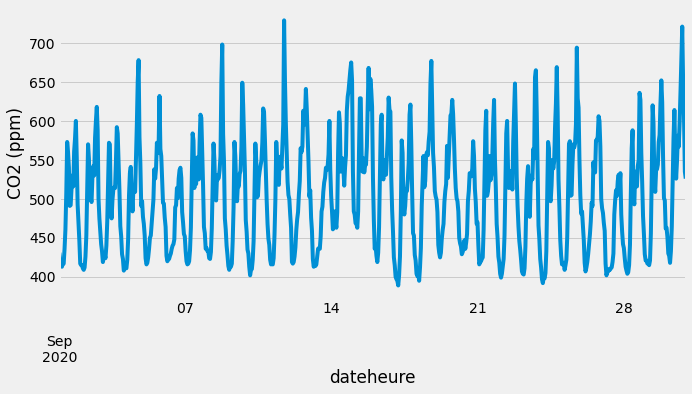

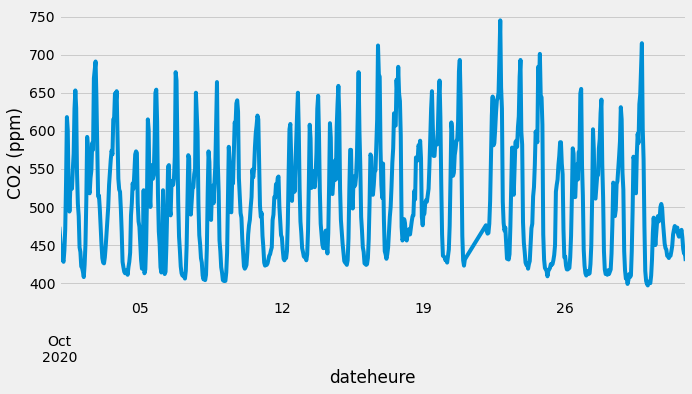

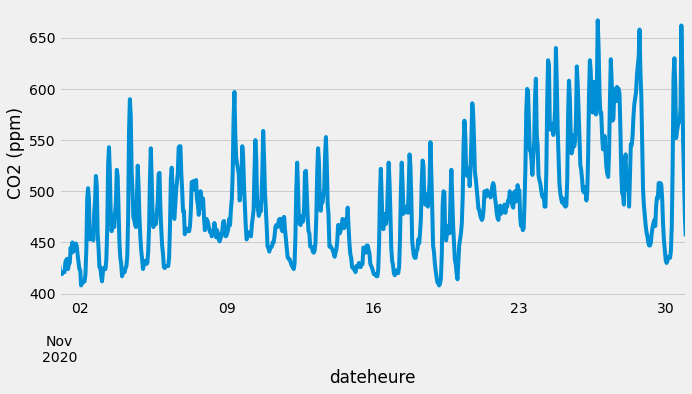

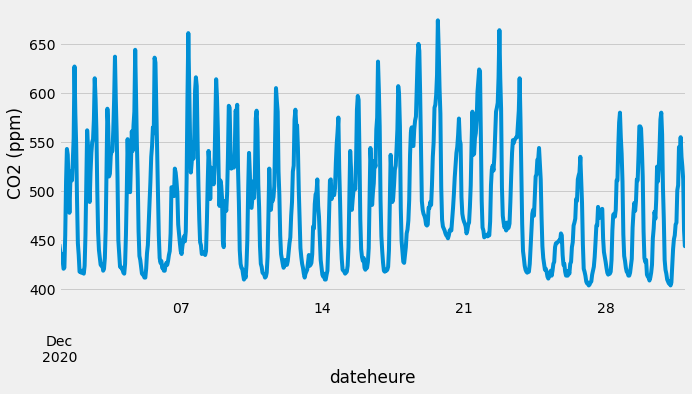

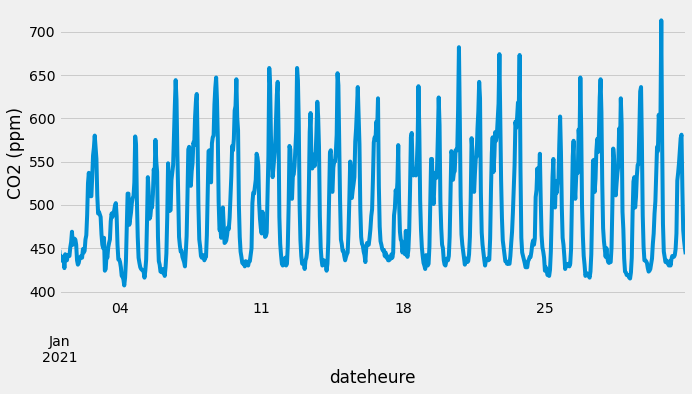

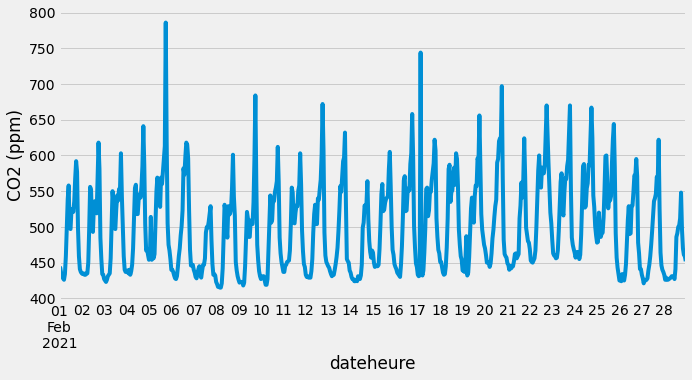

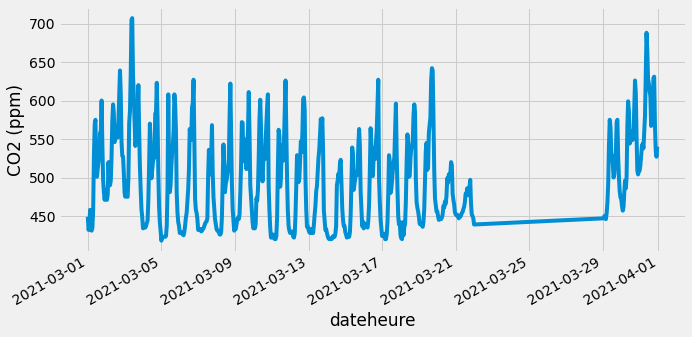

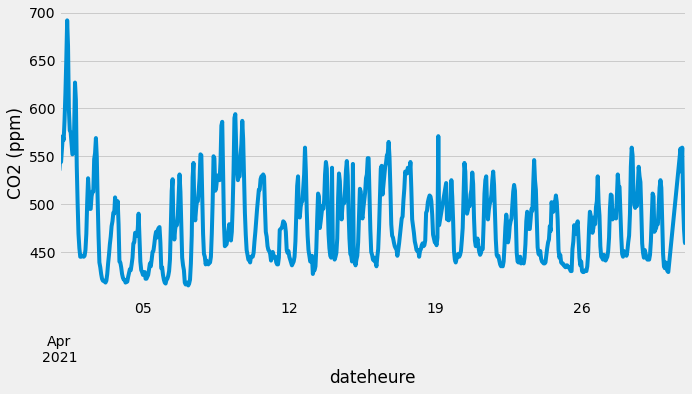

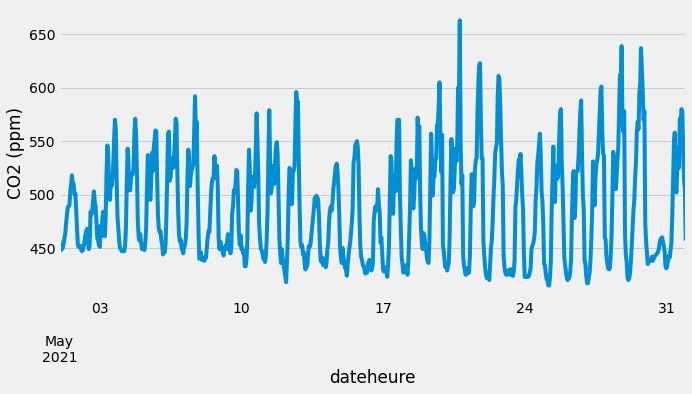

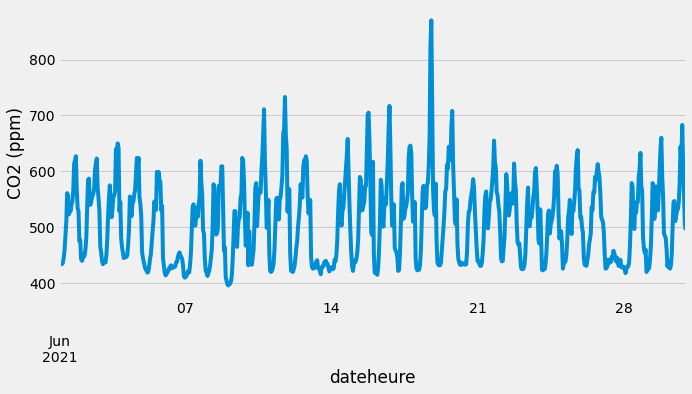

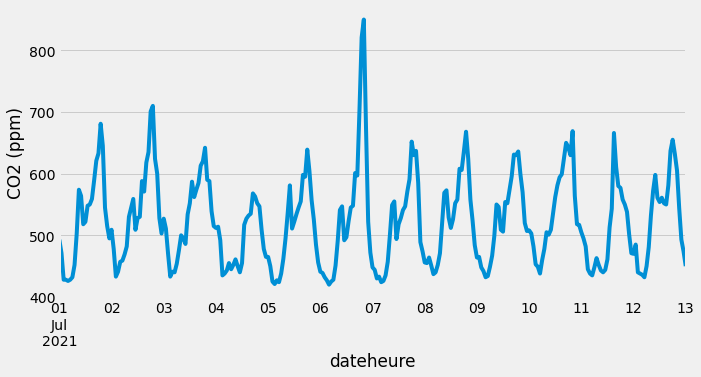

In [12]:
groups = dataset['2020-06':'2021-07'].groupby(pd.Grouper(freq='M'))

for name, group in groups:
    group.plot(figsize=(10,5))
    plt.ylabel('CO2 (ppm)')
    plt.show()
    print()

Il ne semble toujours pas y a voir de tendance.  

Cependant, nous distinguons désormais les **cycles journaliers**. 


### Regroupement par jour

Regardons par exemple les 7 premiers jours du mois de juin. 

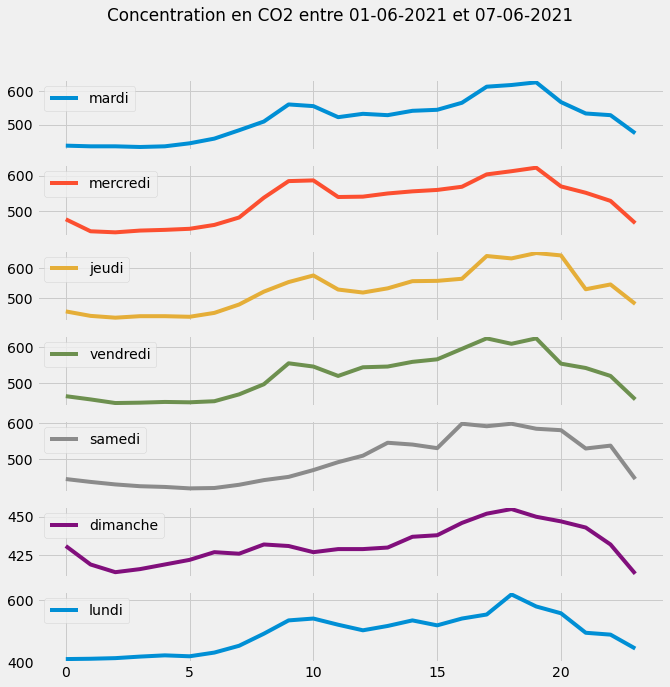

In [13]:
groups = dataset['2021-06-01':'2021-06-07'].groupby(pd.Grouper(freq='D'))
days = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
df_days = pd.DataFrame()

for name, group in groups:
    df_days[days[name.weekday()]] = group.values

df_days.plot(subplots=True, 
             legend=True,  # à enlever si encombrement
             figsize=(10,10),
             title='Concentration en CO2 entre 01-06-2021 et 07-06-2021');

Le comportement cyclique journalier se confirme sur ce petit échantillon.  

Les points suivants sont récurrents :
* la concentration ne descend pas en dessous de 400 ppm
* elle augmente souvent à partir de 5h-6h pour atteindre un premier pic autour de 9h-10h
* elle diminue très légèrement avant d'augmenter à nouveau avant 15h pour atteindre un 2e pic autour de 18h
* elle finit par diminuer tout au long de la soirée
* du lundi au samedi, le 2e pic monte à 600 ppm, seul le dimanche cette valeur est plus faible, autour de 450 ppm. 

Ces deux pics se situent pendant les périodes de déplacement travail-domicile. 

## Density plot

Certains modèles de prévision de série temporelle supposent que les données suivent une distribution gaussienne. 

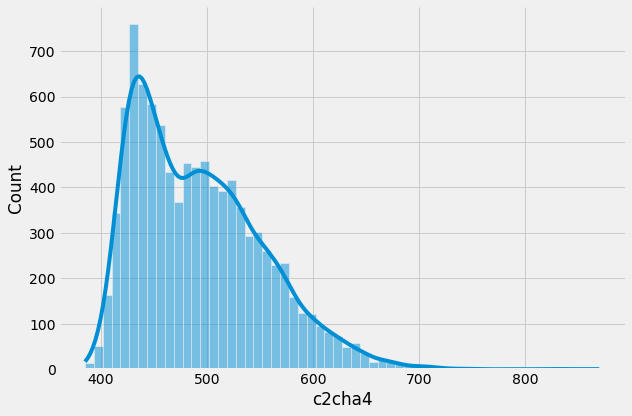

In [15]:
sns.displot(x=dataset, kde=True, height=6, aspect=1.5);

La distribution n'est pas gaussienne. 

## Box Plots

Nous regroupons les données par mois pour observer leur évolution.   
Rappelons que le mois de juillet est incomplet. 

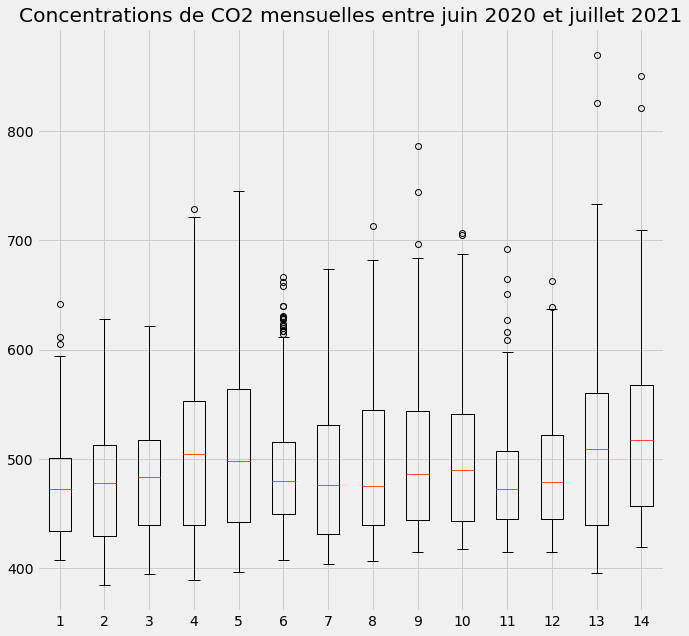

In [237]:
groups = dataset['2020-06':'2021-07'].groupby(pd.Grouper(freq='M'))

list_groups = list()
for name, group in groups : 
    list_groups.append(group)

plt.figure(figsize=(10,10))    
plt.boxplot(list_groups)
plt.title('Concentrations de CO2 mensuelles entre juin 2020 et juillet 2021');

Les médianes suggèrent une certaine cyclicité tous les 5 à 7 mois, de faible amplitude.

Les écart-interquartiles sont assez stables dans l'ensemble.  

Il y a des outliers, qui correspondent à des pics journaliers plus importants : 
* ils sont tous supérieurs à 600 ppm
* la plupart sont comprises entre 600 et 700 ppm
* les outliers plus prononcés sont au-delà de 700 ppm
* il n'y a pas d'outliers 'vers le bas', avec des valeurs particulièrement faibles. 

# Sources

* [afficher les box-plot à partir d'une liste d'arrays 1D](https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/)


# Notes techniques

* Souvent, on utilise le découpage train / validation / test, ici on a nommé dans l'ordre train / test / validation. 
* Dans le regroupement par mois, on n'a pas pu construire un dataframe (comme pour le regroupement par jour) pour afficher avec un seul plot car les mois n'ont pas le même nombre de jours.